In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import numpy as np
import os
import pandas as pd
import scipy as sp
import sys
import torch
import torch.nn.functional as F
import warnings
import random
import collections

# CD-T Imports
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pickle
import json

from torch import nn

warnings.filterwarnings("ignore")

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from argparse import Namespace
from methods.bag_of_ngrams.processing import cleanReports, cleanSplit, stripChars
from pyfunctions.general import extractListFromDic, readJson, combine_token_attn, compute_word_intervals
from pyfunctions.pathology import extract_synoptic, fixLabelProstateGleason, fixProstateLabels, fixLabel, exclude_labels
from pyfunctions.patch import *
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification

In [3]:
torch.autograd.set_grad_enabled(False)

## Model Arguments

In [4]:
args = {
    'model_type': 'bert', # bert, medical_bert, pubmed_bert, biobert, clinical_biobert
    'task': 'path',
    'field': 'PrimaryGleason'
}

device = 'cpu'

In [5]:
if args['model_type'] == 'bert':
    bert_path = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
elif args['model_type'] == 'medical_bert':
    bert_path = f"{base_dir}/models/pretrained/bert_pretrain_output_all_notes_150000/"
    tokenizer = BertTokenizer.from_pretrained(bert_path, local_files_only=True)
elif args['model_type'] == 'pubmed_bert':
    bert_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")
elif args['model_type'] == 'pubmed_bert_full':
    bert_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
elif args['model_type'] == 'biobert':
    bert_path = "dmis-lab/biobert-v1.1"
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
elif args['model_type'] == 'clinical_biobert':
    bert_path = "emilyalsentzer/Bio_ClinicalBERT"
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

## Load data

you can cutomize the code here to read in your own data.

In [6]:
# Read in data
#field = 'PrimaryGleason' # out of PrimaryGleason, SecondaryGleason', 'MarginStatusNone', 'SeminalVesicleNone'
path = f"../data/prostate.json"
data = readJson(path)

# Clean reports
data = cleanSplit(data, stripChars)
data['dev_test'] = cleanReports(data['dev_test'], stripChars)
data = fixLabel(data)

train_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['train']]
val_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['val']]
test_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['test']]
print(len(train_documents), len(val_documents),len(test_documents))

Token indices sequence length is longer than the specified maximum sequence length for this model (1345 > 512). Running this sequence through the model will result in indexing errors


2066 517 324


In [7]:
# Create datasets
train_labels = [patient['labels'][args['field']] for patient in data['train']]
val_labels = [patient['labels'][args['field']] for patient in data['val']]
test_labels = [patient['labels'][args['field']] for patient in data['test']]

train_documents, train_labels = exclude_labels(train_documents, train_labels)
val_documents, val_labels = exclude_labels(val_documents, val_labels)
test_documents, test_labels = exclude_labels(test_documents, test_labels)

le = preprocessing.LabelEncoder()
le.fit(train_labels)

# Map raw label to processed label
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
le_dict = {str(key):le_dict[key] for key in le_dict}

for label in val_labels + test_labels:
    if str(label) not in le_dict:
        le_dict[str(label)] = len(le_dict)

# Map processed label back to raw label
inv_le_dict = {v: k for k, v in le_dict.items()}

In [8]:
documents_full = train_documents + val_documents + test_documents
labels_full = train_labels + val_labels + test_labels

## Load Trained Models

In [9]:
#load finetuned model
model_path = f"{base_dir}/PG_best_ckpts/bert" # /{args['model_type']}_{args['field']}"
checkpoint_file = f"{model_path}/save_output"
# config_file = f"{model_path}/save_output/config.json"

model = BertForSequenceClassification.from_pretrained(checkpoint_file, num_labels=len(le_dict), output_hidden_states=True)

model = model.eval()
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Test systematic bias and collect head activations

In [18]:
# variance of head output across samples
# size of head output (context) -> torch.Size([1, 512, 768])

with torch.no_grad():
    NUM_SAMPLES = 500
    POS = 0
    index_lst = random.sample(range(0, len(documents_full)), NUM_SAMPLES)
    docs = [documents_full[i] for i in index_lst]
    
    collect = []
    for doc in tqdm.tqdm(docs):
        encoding = get_encoding(doc, tokenizer, device)
        _, _, _, context_lst = prop_classifier_model_patched(encoding, model, device, [], output_context=True)
        context = np.stack(context_lst)
        context_at_pos = context[:, :, POS, :, :].transpose(1,0,2,3).squeeze(0) #[layer, head, d]
        collect.append(context_at_pos)
    collect = np.stack(collect)

100%|██████████| 500/500 [03:27<00:00,  2.41it/s]


In [33]:
collect.shape


(200, 12, 1, 512, 12, 64)

In [34]:
mean_acts = np.mean(collect.squeeze(2), axis=0)
print(mean_acts.shape)
path = f"{base_dir}/output/"

with open(os.path.join(path, f"{args['model_type']}_mean_acts_random_500.pkl"), 'wb') as handle:
    pickle.dump(mean_acts, handle)

(12, 512, 12, 64)


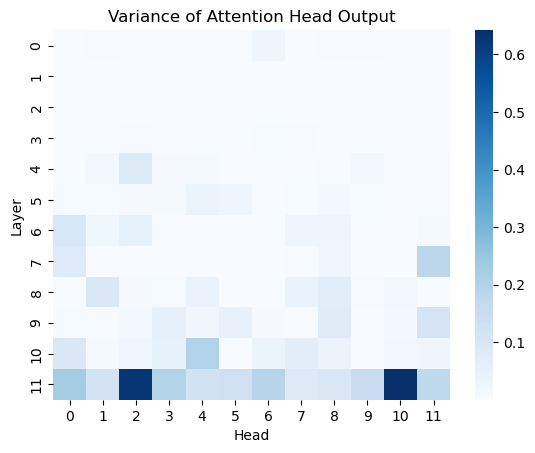

In [86]:
var_context = np.var(collect, axis=0) #collect = [N, layer, head, d]
avg_var = np.mean(var_context, axis=-1)

s = sns.heatmap(avg_var, xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': ''})
s.set(xlabel='Head', ylabel='Layer')
plt.title("Variance of Attention Head Output")
plt.show()

## Head to logits direct influence

In [11]:
doc = documents_full[0]
label = labels_full[0]
encoding = get_encoding(doc, tokenizer, device)
# label_idx = le_dict[label]
    
patched_entry = [(0, 0, 0)]

rel, irrel, _, _ = prop_classifier_model_patched(encoding, model, device, patched_entry,
                                                             patched_values=None,
                                                             mean_ablated=False)

torch.Size([1, 512, 768])
torch.Size([768, 768])
torch.Size([1, 512, 768])
torch.Size([768, 768])
torch.Size([1, 512, 768])
torch.Size([768, 3072])
torch.Size([1, 512, 3072])
torch.Size([3072, 768])
torch.Size([1, 512, 768])
torch.Size([768, 768])
torch.Size([1, 512, 768])
torch.Size([768, 768])
torch.Size([1, 512, 768])
torch.Size([768, 3072])
torch.Size([1, 512, 3072])
torch.Size([3072, 768])
torch.Size([1, 512, 768])
torch.Size([768, 768])
torch.Size([1, 512, 768])
torch.Size([768, 768])
torch.Size([1, 512, 768])
torch.Size([768, 3072])
torch.Size([1, 512, 3072])
torch.Size([3072, 768])
torch.Size([1, 512, 768])
torch.Size([768, 768])
torch.Size([1, 512, 768])
torch.Size([768, 768])
torch.Size([1, 512, 768])
torch.Size([768, 3072])
torch.Size([1, 512, 3072])
torch.Size([3072, 768])
torch.Size([1, 512, 768])
torch.Size([768, 768])
torch.Size([1, 512, 768])
torch.Size([768, 768])
torch.Size([1, 512, 768])
torch.Size([768, 3072])
torch.Size([1, 512, 3072])
torch.Size([3072, 768])
torch

In [27]:
rel.shape
irrel.shape
model.classifier

Linear(in_features=768, out_features=3, bias=True)

In [11]:
def patch_h_to_logits_at_pos(encoding, model, pos, label_idx, device, mean_act=None, mean_ablated=False):
    # patch one node at a time
    raw_logit = model(**encoding)[0][0][label_idx] # == raw_irrel
    h_ctbn_lst = []
    for level in range(12):
        h_ctbn_lst.append([])
        for h in range(12):
            patched_entry = [(level, pos, h)]
            rel, irrel, _, _ = prop_classifier_model_patched(encoding, model, device, patched_entry,
                                                             patched_values=mean_act,
                                                             mean_ablated=mean_ablated)
            rel = rel[0][label_idx] # head ctbn
            h_ctbn_lst[level].append(rel / abs(raw_logit) * 100)

        h_ctbn_lst[level] = torch.stack(h_ctbn_lst[level])
    h_ctbn_tot = torch.stack(h_ctbn_lst).cpu().numpy()
    return h_ctbn_tot

In [12]:
# load in the mean (pre-collected) to do mean ablation
path = f"{base_dir}/output/{args['task']}/{args['model_type']}_{args['field']}/h_to_logits"
os.makedirs(path, exist_ok=True)

with open(os.path.join(path, f"mean_head_out_res_500.pkl"), 'rb') as handle:
    back = pickle.load(handle)

In [439]:
# zero-ablating single head at a time [this code also allows you to ablate multiple heads]
# h -> logits

with torch.no_grad():
    NUM_SAMPLES = 200
    POS = 0
    index_lst = random.sample(range(0, len(documents_full)), NUM_SAMPLES)
    docs = [documents_full[i] for i in index_lst]
    labels = [labels_full[i] for i in index_lst]

    h_ctbn = []
    for doc, label in tqdm.tqdm(zip(docs, labels)):
        encoding = get_encoding(doc, tokenizer, device)
        label_idx = le_dict[label]
        h_ctbn_tot = patch_h_to_logits_at_pos(encoding, model, POS, label_idx, device)
        h_ctbn.append(h_ctbn_tot) #[12, 12] = [Layer, HEAD]

    h_ctbn = np.stack(h_ctbn)

200it [1:04:24, 19.32s/it]


In [ ]:
# mean-ablating single head at a time [this code also allows you to ablate multiple heads]
# h -> logits
        
with torch.no_grad():
    NUM_SAMPLES = 200
    POS = 0
    index_lst = random.sample(range(0, len(documents_full)), NUM_SAMPLES)
    docs = [documents_full[i] for i in index_lst]
    labels = [labels_full[i] for i in index_lst]

    h_ctbn = []
    for doc, label in tqdm.tqdm(zip(docs, labels)):
        encoding = get_encoding(doc, tokenizer, device)
        label_idx = le_dict[label]
        h_ctbn_tot = patch_h_to_logits_at_pos(encoding, model, POS, label_idx, device,
                                              mean_act=back, mean_ablated=True)
        h_ctbn.append(h_ctbn_tot) #[12, 12] = [Layer, HEAD]

    h_ctbn = np.stack(h_ctbn)

In [440]:
avg_h_ctbn = np.mean(h_ctbn, axis=0) #avg over samples

In [17]:
path = f"{base_dir}/output/{args['task']}/{args['model_type']}_{args['field']}/h_to_logits"
os.makedirs(path, exist_ok=True)

#with open(os.path.join(path, f"singleH_{NUM_SAMPLES}_nov15.pkl"), 'wb') as handle:
#    pickle.dump(avg_h_ctbn, handle)
    
with open(os.path.join(path, f"singleH_200_mean_ablated_nov15.pkl"), 'rb') as handle:
    back = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/georgiazhou/research-machine1/CD_Circuit/output/path/bert_PrimaryGleason/h_to_logits/singleH_200_mean_ablated_nov15.pkl'

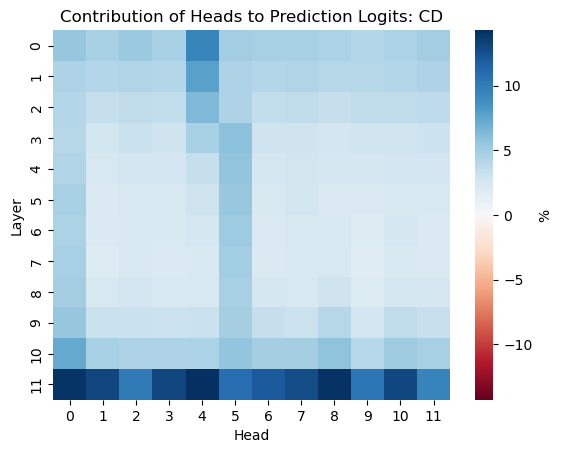

In [441]:
# if you want to visualize the effect of each head to logits in a heatmap...
# this plot is from zero-ablation

cm_max = max(avg_h_ctbn.flatten())
cm_min = -cm_max

s = sns.heatmap(avg_h_ctbn, xticklabels = range(12), yticklabels = range(12), cmap='RdBu', cbar_kws={'label': '%'},
               vmin=cm_min, vmax=cm_max)
s.set(xlabel='Head', ylabel='Layer')
plt.title(f"Contribution of Heads to Prediction Logits: CD")
plt.show()

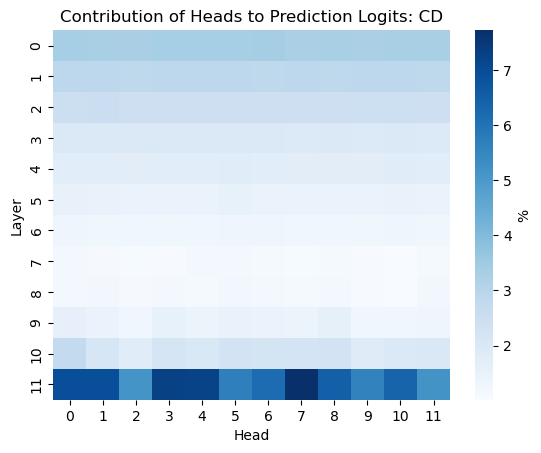

In [26]:
# if you want to visualize the effect of each head to logits in a heatmap...
# this plot is from mean-ablation

s = sns.heatmap(back, xticklabels = range(12), yticklabels = range(12), cmap='Blues', cbar_kws={'label': '%'})
s.set(xlabel='Head', ylabel='Layer')
plt.title(f"Contribution of Heads to Prediction Logits: CD")
plt.show()

## Extract top N heads and their attended words

In [ ]:
# a is the calcuated effect of each head on the logits

N = 6
a = back
top_idxs = np.argsort(a.ravel())[-N:]
rows, cols = top_idxs//12, top_idxs%12

positives = []
for r, c in zip(rows, cols):
    positives.append((r, c))

In [12]:
def collect_attended_tokens(positives_heads, device, tokenizer, N=100, Z_thres=2, POS=0):
    index_lst = random.sample(range(0, len(documents_full)), N)
    docs = [documents_full[i] for i in index_lst]
    
    collect = collections.defaultdict(int)
    for doc in docs:
        encoding = get_encoding(doc, tokenizer, device)
        raw_rel, raw_irrel, raw_att_probs_lst, _ = prop_classifier_model_patched(encoding, model, device, [], output_att_prob=True)
        raw_att_probs = torch.stack(raw_att_probs_lst).cpu().numpy()

        avg_att_m = np.zeros((512))
        for level, h in positives:
            att_m = raw_att_probs[level, h, POS, :]
            avg_att_m += att_m

        avg_att_m /= len(positives)
        
        # convert to word level
        interval_dict, word_lst = compute_word_intervals(encoding, tokenizer)
        word_att_m = combine_token_attn(interval_dict, avg_att_m)
        
        Z = (word_att_m - np.mean(word_att_m)) / np.std(word_att_m)

        positive_words = np.where(Z > Z_thres)
        
        for w_idx in positive_words[0]:
            w = word_lst[w_idx]
            #collect[w] += 1
            collect[w] += word_att_m[w_idx]
            
    return collect

In [13]:
positive_attended_token_freq = collect_attended_tokens(positives, device, tokenizer, N=500, Z_thres=2)
positive_attended_token_freq = sorted(positive_attended_token_freq.items(), key=lambda k_v: k_v[1], reverse=True)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_825660/1888346581.py:1 in <module>                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_825660/1888346581.py'                       │
│                                                                                                  │
│ /tmp/ipykernel_825660/4109569869.py:12 in collect_attended_tokens                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_825660/4109569869.py'                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: too many values to unpack (expected 2)

In [109]:
with open('result_top1.json', 'w') as fp:
    json.dump(positive_attended_token_freq, fp)

## Extra: Ablate with means of different label groups

In [ ]:
label_idx_4_5 = [] #934
label_idx_4 = [] #855
label_idx_5 = [] #79
label_idx_3 = [] #1934

for i, x in enumerate(labels_full):
    if x == '4':
        label_idx_4_5.append(i)
        label_idx_4.append(i)
    elif x == '5':
        label_idx_4_5.append(i)
        label_idx_5.append(i)
    elif x == '3':
        label_idx_3.append(i)

In [ ]:
path = f"{base_dir}/output/{args['task']}/{args['model_type']}_{args['field']}/h_to_logits"
os.makedirs(path, exist_ok=True)

#with open(os.path.join(path, f"mean_head_out_res_{NUM_SAMPLES}.pkl"), 'wb') as handle:
#    pickle.dump(mean_act, handle)
    
with open(os.path.join(path, f"mean_head_out_res_label4_5_500.pkl"), 'rb') as handle:
    back = pickle.load(handle)

In [ ]:
with torch.no_grad():
    NUM_SAMPLES = 200
    POS = 0
    index_lst = random.sample(label_idx_3, NUM_SAMPLES)
    docs = [documents_full[i] for i in index_lst]
    labels = [labels_full[i] for i in index_lst]

    h_ctbn = []
    for doc, label in tqdm.tqdm(zip(docs, labels)):
        encoding = get_encoding(doc, tokenizer, device)
        label_idx = le_dict[label]
        h_ctbn_tot = patch_h_to_logits_at_pos(encoding, model, POS, label_idx, device,
                                              mean_act=back, mean_ablated=True)
        h_ctbn.append(h_ctbn_tot) #[12, 12] = [Layer, HEAD]

    h_ctbn = np.stack(h_ctbn)